# Exercise 4: Neural Networks Learning 

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd

from pandas import DataFrame as dframe

## Neural Network 

### Visualizing the Data 

In [2]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
num_labels = 10;          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)   %% Setup the parameters you will use for this exercise

In [3]:
# =========== Part 1: Loading and Visualizing Data =============
data = sio.loadmat('ex4data1.mat')

In [4]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [5]:
# Storing X and y values to respective variables
X = data['X']
y = data['y']

In [6]:
# Since python indexing starts from 0
# And to provide suitability to weight, '1' will be substracted from y
# Thus, making each value in y corresponds to class k+1 where k = [1..9] with caveat that '9' will classified as '0'
y = y-1

In [7]:
y

array([[9],
       [9],
       [9],
       ...,
       [8],
       [8],
       [8]], dtype=uint8)

In [8]:
y.shape, type(y)

((5000, 1), numpy.ndarray)

In [9]:
X.shape

(5000, 400)

In [10]:
# As always add intercept/bias term to X
X = np.insert(X, 0, 1, axis=1)

In [11]:
def displayData(sample): 
    '''
    Visualizing the data inside sample
    '''
    # Remove bias term column wise, if exists in sample data
    if np.array_equal(sample[:, 0], np.ones(sample.shape[0])):
        sample = np.delete(sample, 0, axis=1)

    (m, n) = sample.shape
    
    # These are built purposely to handle X and theta1[:1, :] in part 8
    if m > 100:
        side = 10
    else:
        side = int(np.sqrt(m))
    
    rp = np.random.permutation(m)

    figure, ax = plt.subplots(side, side, figsize=(side, side))
    for i in range(side):
        for j in range(side):
            pic = sample[rp[i*side+j], :].reshape(20, 20, order='F')
            ax[i, j].imshow(pic, cmap='gray')
            ax[i, j].axis('off')

    plt.show()

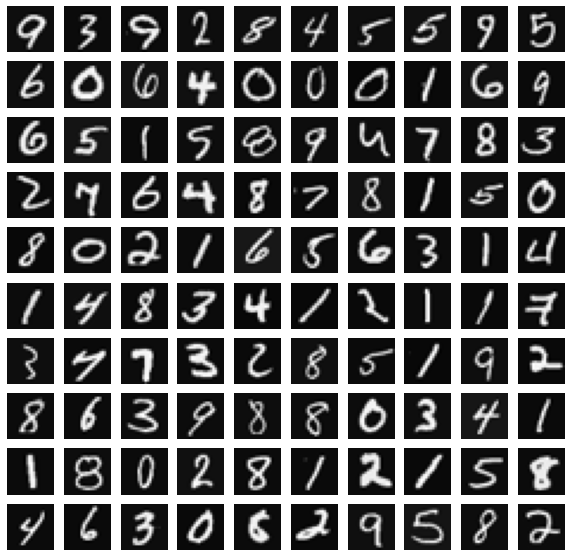

In [12]:
# Data Visualization
displayData(X)

### Model Representation
![nn](./img/nn.png)

In [13]:
# ================ Part 2: Loading Parameters ================
# Load the weights into respective variables
theta = sio.loadmat('ex4weights.mat')
theta1 = theta['Theta1']
theta2 = theta['Theta2']

In [14]:
theta1.shape, theta2.shape 

((25, 401), (10, 26))

In [15]:
# Unroll both variables for future
# Note that the both ravel() and flatten() will unroll array column-wise, the opposite of MATLAB
# In order to get the same unrolled array as MATLAB set the order to 'F'
nn_params = np.hstack([theta1.ravel(order='F'), theta2.ravel(order='F')])

In [16]:
def sigmoid(z):
    sig = 1/(1+np.exp(-z))
    return sig

# This will actually introduced later
def sigmoidGradient(z):
    '''
    SIGMOIDGRADIENT returns the gradient of the sigmoid function evaluated at z
       g = SIGMOIDGRADIENT(z) computes the gradient of the sigmoid function
       evaluated at z. This should work regardless if z is a matrix or a
       vector. In particular, if z is a vector or matrix, you should return
       the gradient for each element.
    '''
    g = sigmoid(z) * (1 - sigmoid(z));
    
    return g

In [17]:
# ================ Part 3: Compute Cost (Feedforward) ================
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambd):
    '''
     [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
     X, y, lambda) computes the cost and gradient of the neural network of two layers. 
     
     The parameters for the neural network are "unrolled" into the vector nn_params and 
     need to be converted back into the weight matrices. 
     
     The returned parameter grad should be a "unrolled" vector of the
     partial derivatives of the neural network.
     
     Note that the X passed into this function supposed to already have has bias term
    '''
    # Add bias term if X doesnt have it
    if not np.array_equiv(X[:, 0], np.ones(1)):
        X = np.insert(X, 0, 1, axis=1)
    
    # Reshape nn_params back to theta1 and theta2
    theta1 = nn_params[:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size, -1, order='F')
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels, -1, order='F')    
    
    # Some useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly 
    J = 0;
    Theta1_grad = np.zeros(theta1.shape);
    Theta2_grad = np.zeros(theta2.shape);
    
    # ==== FORWARD PROPAGATION ===
    # == Input Layer ==
    a1 = X # activation unit 1
    
    # == Hidden Layer ==
    # z unit in hidden layer
    z2 = theta1@a1.T # 5000 x 401 @ 401 x 25 = 5000 x 25
    
    # activation unit in hidden layer
    a2 = sigmoid(z2) # 5000 x 25
    a2 = np.insert(a2.T, 0, 1, axis=1) # adding bias term to a2, 5000 x 26
    
    # == Output Layer ==
    # z unit in hidden layer
    z3 = theta2@a2.T # 5000 x 26 @ 26 x 10 = 5000 x 10
    
    # activation unit in output layer
    a3 = sigmoid(z3) # 5000 x 10 
    a3 = a3.T
    
    # Expanding y vector to matrix Y with dimension of 5000 x 10, containing a single value
    I = np.eye(num_labels)
    
    Y = I[y, :].reshape(-1, num_labels) # y now has shape 5000 x 10
    
    # Regularization
    reg = lambd/(2*m) * (np.sum(theta1[:, 1:]**2) + np.sum(theta2[:, 1:]**2)) 
    
    # Cost function
    J = -1/m * np.sum([np.log(a3)*(Y)+(np.log(1-a3)*(1-Y))]) + reg
    
    # ==== BACK PROPAGATION ===
    # == Output Layer ==
    d3 = a3 - Y # 5000 x 10

    # == Hidden Layer ==
    d2 = d3 @ theta2[:,1:] * sigmoidGradient(z2).T # 5000 x 10 @ 10 x 25 * 5000 x 25 = 5000 x 25
    
    # Initialize delta value
    Delta1 = 0;
    Delta2 = 0;

    Delta1 = Delta1 + d2.T @ a1; # 25 x 5000 @ 5000 x 401
    Delta2 = Delta2 + d3.T @ a2; # 10 x 5000 @ 5000 x 26
    
    Theta1_grad = 1/m * Delta1; # dim 25*401
    Theta2_grad = 1/m * Delta2; # dim 10*26

    # REGULARIZATION
    Theta1_grad[:,1:] = Theta1_grad[:,1:] + (lambd/m) * theta1[:,1:];
    Theta2_grad[:,1:] = Theta2_grad[:,1:] + (lambd/m) * theta2[:,1:];
    
    
    grad = np.hstack([Theta1_grad.ravel(order='F'), Theta2_grad.ravel(order='F')])
    
    return J, grad

In [18]:
def checkNNGradients(lambd=0):
    # CHECKNNGRADIENTS Creates a small neural network to check the backpropagation gradients
    #    CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
    #    backpropagation gradients, it will output the analytical gradients
    #    produced by your backprop code and the numerical gradients (computed
    #    using computeNumericalGradient). These two gradient computations should
    #    result in very similar values.
    
    # lambda value is default to 0, or is passed otherwise
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size);
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size);

    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1)
    y  = np.mod(range(1, m+1), num_labels)
    
    # Unroll parameters
    nn_params = np.hstack([Theta1.ravel(order='F'), Theta2.ravel(order='F')])
    
    # Short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambd)
    
    [cost, grad] = costFunc(nn_params)
    
    numgrad = computeNumericalGradient(costFunc, nn_params)
    
    # Visually examine the two gradient computations.  The two columns you get should be very similar. 
    print('These two columns should hold similar values')
    print('grad \t\tnumgrad')

    print(np.array2string(np.c_[grad, numgrad], precision=5), '\n')
    
    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print('If your backpropagation implementation is correct, then the relative difference will be small (less than 1e-9),\nRelative Difference:', diff)

In [19]:
def debugInitializeWeights(fan_out, fan_in):
    # Set W to zeros
    W = np.zeros([fan_out, fan_in+1])
    
    # Initialize W using "sin", this ensures that W is always of the same values and will be useful for debugging
    W = np.sin(np.arange(1, W.size+1)).reshape(fan_out, fan_in+1, order='F')/10
    
    return W

In [20]:
def computeNumericalGradient(J, theta):
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4
    
    for p in range(theta.size):
        perturb[p] = e
        loss1 = J(theta-perturb)[0]
        loss2 = J(theta+perturb)[0]
        
        # Compute numerical gradient
        numgrad[p] = (loss2-loss1) / (2*e)
        perturb[p] = 0
    
    return numgrad

### Feedforward and Cost Function

In [21]:
# First is computing the cost without regularization term, lambda is set to 0
λ = 0
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, λ)[0] # Only returning first value

In [22]:
J

0.2876291651613189

In [23]:
print('Cost at parameters (loaded from ex4weights): %.8f' %J)
print('(this value should be about 0.287629)')

Cost at parameters (loaded from ex4weights): 0.28762917
(this value should be about 0.287629)


### Regularized cost function

In [24]:
# =============== Part 4: Implement Regularization ===============
λ = 1

In [25]:
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, λ)[0]

In [26]:
J

0.38376985909092365

In [27]:
print('Cost at parameters (loaded from ex4weights): %.8f' %J)
print('(this value should be about 0.383770)')

Cost at parameters (loaded from ex4weights): 0.38376986
(this value should be about 0.383770)


## Backpropagation

### Sigmoid gradient
First implement the sigmoid gradient function. 
![sigmoid-grad](./img/sigmoid-grad.png)

where
![sigmoid](./img/sigmoid.png)

In [28]:
# ================ Part 5: Sigmoid Gradient  ================
# Before you start implementing the neural network, you will first
# implement the gradient for the sigmoid function. You should complete the code in the sigmoidGradient

def sigmoidGradient(z):
    '''
    SIGMOIDGRADIENT returns the gradient of the sigmoid function evaluated at z
       g = SIGMOIDGRADIENT(z) computes the gradient of the sigmoid function
       evaluated at z. This should work regardless if z is a matrix or a
       vector. In particular, if z is a vector or matrix, you should return
       the gradient for each element.
    '''
    g = sigmoid(z) * (1 - sigmoid(z));
    
    return g

In [29]:
g = sigmoidGradient(np.array([-1, 0.5, 0, 0.5, 1]))

In [30]:
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n', g);

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
 [0.19661193 0.23500371 0.25       0.23500371 0.19661193]


### Random initialization

In [31]:
# ================ Part 6: Initializing Pameters ================
# Initialized parameter for neural netowork to classify 0-9 digits

def randInitializeWeights(L_in, L_out):
    '''
    RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
    incoming connections and L_out outgoing connections
       
    W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
    of a layer with L_in incoming connections and L_out outgoing 
    connections. 
    
    Note that W should be set to a matrix of size(L_out, 1 + L_in) as
    the first column of W handles the "bias" terms
    '''
    
    epsilon_init = 0.12;
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init;
    
    return W

In [32]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

In [33]:
# Verify the shape of each parameters
(initial_Theta1.shape, initial_Theta2.shape)

((25, 401), (10, 26))

In [34]:
# Unroll both variables for future
initial_nn_params = np.hstack([initial_Theta1.ravel(order='F'), initial_Theta2.ravel(order='F')])

In [35]:
print(initial_nn_params); initial_nn_params.shape

[-0.08073227 -0.119843    0.11364313 ... -0.0774982   0.04452116
  0.08733157]


(10285,)

### Backpropagation
![backprop](./img/backprop.png)

### Gradient checking

In [36]:
# =============== Part 7: Implement Backpropagation ===============
# Note that the relative difference is quite different than MATLAB's
# but it satisfies the condition less than 1e-9
print('Checking Backpropagation... \n')
checkNNGradients()

Checking Backpropagation... 

These two columns should hold similar values
grad 		numgrad
[[-9.27825e-03 -9.27825e-03]
 [ 8.89912e-03  8.89912e-03]
 [-8.36011e-03 -8.36011e-03]
 [ 7.62814e-03  7.62814e-03]
 [-6.74798e-03 -6.74798e-03]
 [-3.04979e-06 -3.04979e-06]
 [ 1.42869e-05  1.42869e-05]
 [-2.59383e-05 -2.59383e-05]
 [ 3.69883e-05  3.69883e-05]
 [-4.68760e-05 -4.68760e-05]
 [-1.75060e-04 -1.75060e-04]
 [ 2.33146e-04  2.33146e-04]
 [-2.87469e-04 -2.87469e-04]
 [ 3.35320e-04  3.35320e-04]
 [-3.76216e-04 -3.76216e-04]
 [-9.62661e-05 -9.62661e-05]
 [ 1.17983e-04  1.17983e-04]
 [-1.37150e-04 -1.37150e-04]
 [ 1.53247e-04  1.53247e-04]
 [-1.66560e-04 -1.66560e-04]
 [ 3.14545e-01  3.14545e-01]
 [ 1.11057e-01  1.11057e-01]
 [ 9.74007e-02  9.74007e-02]
 [ 1.64091e-01  1.64091e-01]
 [ 5.75736e-02  5.75736e-02]
 [ 5.04576e-02  5.04576e-02]
 [ 1.64568e-01  1.64568e-01]
 [ 5.77867e-02  5.77867e-02]
 [ 5.07530e-02  5.07530e-02]
 [ 1.58339e-01  1.58339e-01]
 [ 5.59235e-02  5.59235e-02]
 [ 4.91621e

### Regularized Neural Networks
![reg_backprop](./img/reg_backprop.png)

In [37]:
# =============== Part 8: Implement Regularization ===============
print('Checking Backpropagation (w/ Regularization) ... \n')

lambd = 3
checkNNGradients(lambd = 3)

Checking Backpropagation (w/ Regularization) ... 

These two columns should hold similar values
grad 		numgrad
[[-9.27825e-03 -9.27825e-03]
 [ 8.89912e-03  8.89912e-03]
 [-8.36011e-03 -8.36011e-03]
 [ 7.62814e-03  7.62814e-03]
 [-6.74798e-03 -6.74798e-03]
 [-1.67680e-02 -1.67680e-02]
 [ 3.94335e-02  3.94335e-02]
 [ 5.93356e-02  5.93356e-02]
 [ 2.47641e-02  2.47641e-02]
 [-3.26881e-02 -3.26881e-02]
 [-6.01745e-02 -6.01745e-02]
 [-3.19612e-02 -3.19612e-02]
 [ 2.49226e-02  2.49226e-02]
 [ 5.97718e-02  5.97718e-02]
 [ 3.86411e-02  3.86411e-02]
 [-1.73705e-02 -1.73705e-02]
 [-5.75659e-02 -5.75659e-02]
 [-4.51964e-02 -4.51964e-02]
 [ 9.14588e-03  9.14588e-03]
 [ 5.46102e-02  5.46102e-02]
 [ 3.14545e-01  3.14545e-01]
 [ 1.11057e-01  1.11057e-01]
 [ 9.74007e-02  9.74007e-02]
 [ 1.18683e-01  1.18683e-01]
 [ 3.81929e-05  3.81929e-05]
 [ 3.36927e-02  3.36927e-02]
 [ 2.03987e-01  2.03987e-01]
 [ 1.17148e-01  1.17148e-01]
 [ 7.54801e-02  7.54801e-02]
 [ 1.25698e-01  1.25698e-01]
 [-4.07588e-03 -4.0

In [38]:
# Also output the costFunction debugging values
debug_J, debug_grad  = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambd);

In [39]:
print('Cost at (fixed) debugging parameters (w/ lambda = %.1f): %f ' %(lambd, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')

Cost at (fixed) debugging parameters (w/ lambda = 3.0): 0.576051 
(for lambda = 3, this value should be about 0.576051)


### Learning parameters using fmincg

In [40]:
# =================== Part 8: Training NN ===================
# This section will use "fmincg" to train the neural network, these advanced optimizers
# are able to train the cost function efficiently when provided with gradient computations

In [41]:
from scipy import optimize as opt

In [42]:
# Define lambda value
lambd = 1

In [43]:
initial_nn_params.shape

(10285,)

In [44]:
# To satisfy the argument pass into scipy.optimize.fmin_cg, 
# function that returns cost function, and function that returns gradient need to be declared separately

def gradDescent(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambd):
    '''
    The returned parameter grad should be a "unrolled" vector of the
    partial derivatives of the neural network.
     
    Note that the X passed into this function supposed to already have has bias term
    '''
    # Add bias term if X doesnt have it
    if not np.array_equiv(X[:, 0], np.ones(1)):
        X = np.insert(X, 0, 1, axis=1)
    
    # Reshape nn_params back to theta1 and theta2
    theta1 = nn_params[:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size, -1, order='F')
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels, -1, order='F')    
    
    # Some useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly 
    Theta1_grad = np.zeros(theta1.shape);
    Theta2_grad = np.zeros(theta2.shape);
    
    # ==== FORWARD PROPAGATION ===
    # == Input Layer ==
    a1 = X # activation unit 1
    
    # == Hidden Layer ==
    # z unit in hidden layer
    z2 = theta1@a1.T # 5000 x 401 @ 401 x 25 = 5000 x 25
    
    # activation unit in hidden layer
    a2 = sigmoid(z2) # 5000 x 25
    a2 = np.insert(a2.T, 0, 1, axis=1) # adding bias term to a2, 5000 x 26
    
    # == Output Layer ==
    # z unit in hidden layer
    z3 = theta2@a2.T # 5000 x 26 @ 26 x 10 = 5000 x 10
    
    # activation unit in output layer
    a3 = sigmoid(z3) # 5000 x 10 
    a3 = a3.T
    
    # Expanding y vector to matrix Y with dimension of 5000 x 10, containing a single value
    I = np.eye(num_labels)
    
    Y = I[y, :].reshape(-1, num_labels) # y now has shape 5000 x 10
    
    # ==== BACK PROPAGATION ===
    # == Output Layer ==
    d3 = a3 - Y # 5000 x 10

    # == Hidden Layer ==
    d2 = d3 @ theta2[:,1:] * sigmoidGradient(z2).T # 5000 x 10 @ 10 x 25 * 5000 x 25 = 5000 x 25
    
    # Initialize delta value
    Delta1 = 0;
    Delta2 = 0;

    Delta1 = Delta1 + d2.T @ a1; # 25 x 5000 @ 5000 x 401
    Delta2 = Delta2 + d3.T @ a2; # 10 x 5000 @ 5000 x 26
    
    Theta1_grad = 1/m * Delta1; # dim 25*401
    Theta2_grad = 1/m * Delta2; # dim 10*26

    # REGULARIZATION
    Theta1_grad[:,1:] = Theta1_grad[:,1:] + (lambd/m) * theta1[:,1:];
    Theta2_grad[:,1:] = Theta2_grad[:,1:] + (lambd/m) * theta2[:,1:];
    
    grad = np.hstack([Theta1_grad.ravel(order='F'), Theta2_grad.ravel(order='F')])
    
    return grad

In [45]:
def nnCostFunct_only(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambd):
    '''
    The returned parameter grad should be a "unrolled" vector of the
    partial derivatives of the neural network.
     
    Note that the X passed into this function supposed to already have has bias term
    '''
    # Add bias term if X doesnt have it
    if not np.array_equiv(X[:, 0], np.ones(1)):
        X = np.insert(X, 0, 1, axis=1)
    
    # Reshape nn_params back to theta1 and theta2
    theta1 = nn_params[:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size, -1, order='F')
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels, -1, order='F')    
    
    # Some useful variables
    m, n = X.shape
        
    # ==== FORWARD PROPAGATION ===
    # == Input Layer ==
    a1 = X # activation unit 1
    
    # == Hidden Layer ==
    # z unit in hidden layer
    z2 = theta1@a1.T # 5000 x 401 @ 401 x 25 = 5000 x 25
    
    # activation unit in hidden layer
    a2 = sigmoid(z2) # 5000 x 25
    a2 = np.insert(a2.T, 0, 1, axis=1) # adding bias term to a2, 5000 x 26
    
    # == Output Layer ==
    # z unit in hidden layer
    z3 = theta2@a2.T # 5000 x 26 @ 26 x 10 = 5000 x 10
    
    # activation unit in output layer
    a3 = sigmoid(z3) # 5000 x 10 
    a3 = a3.T
    
    # Expanding y vector to matrix Y with dimension of 5000 x 10, containing a single value
    I = np.eye(num_labels)
    
    Y = I[y, :].reshape(-1, num_labels) # y now has shape 5000 x 10
    
    # Regularization
    reg = lambd/(2*m) * (np.sum(theta1[:, 1:]**2) + np.sum(theta2[:, 1:]**2)) 
    
    # Cost function
    J = -1/m * np.sum([np.log(a3)*(Y)+(np.log(1-a3)*(1-Y))]) + reg
    
    return J

In [46]:
arg = (input_layer_size, hidden_layer_size, num_labels, X, y.flatten(), lambd)

In [47]:
res = opt.fmin_cg(f=nnCostFunct_only,
                  x0=initial_nn_params,
                  fprime=gradDescent,
                  args=arg, 
                  maxiter=50)

         Current function value: 0.456524
         Iterations: 50
         Function evaluations: 115
         Gradient evaluations: 115


In [48]:
theta1_opt = res[:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size, -1, order='F')

In [49]:
theta2_opt = res[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels, -1, order='F')   

In [50]:
theta1_opt.shape, theta2_opt.shape

((25, 401), (10, 26))

In [51]:
print(res); res.shape

[ 0.11987079  0.34753866  0.62235328 ... -2.58920179 -0.84010751
  1.06192839]


(10285,)

## Visualizing the hidden layer

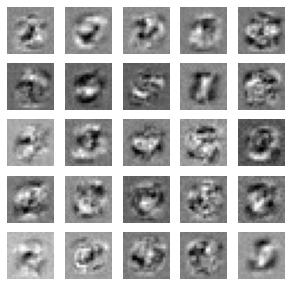

In [52]:
# ================= Part 9: Visualize Weights =================
# "visualize" what the neural network is learning by displaying 
# the hidden units to see what features they are capturing in the data.
displayData(theta1_opt[:, 1:])

In [53]:
# ================= Part 10: Implement Predict =================
#  After training the neural network, the labels of training set will be predicted

def predict(Theta1, Theta2, X):
# PREDICT Predict the label of an input given a trained neural network
#    p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
#    trained weights of a neural network (Theta1, Theta2)
    
    # Add bias term if X doesnt have it
    if not np.array_equiv(X[:, 0], np.ones(1)):
        X = np.insert(X, 0, 1, axis=1)
    
    # Useful values
    m = X.shape[0];
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly
    # This is the output value
    p = np.zeros(m)
    
    h1 = sigmoid(X@Theta1.T)
    h2 = sigmoid(np.hstack([np.ones([len(h1), 1]), h1]) @ Theta2.T)
    
    # Find index where maximum value is in
    idx = np.argmax(h2, axis=1)

    return idx

In [54]:
max_idx = predict(theta1_opt, theta2_opt, X)

In [55]:
# Accuracy
acc = np.mean(max_idx.flatten()==y.flatten())*100

print('Training Set Accuracy: %.3f' %acc + '%')

Training Set Accuracy: 96.640%
